# Percent Change

In [2]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from datetime import datetime,date,timedelta
import seaborn as sns
import os, warnings
from scipy.signal import savgol_filter
%matplotlib inline
warnings.filterwarnings('ignore')
cutOffYear = '1850'

In [3]:
ctrTemp = pd.read_csv('../data/GlobalLandTemperatures/GlobalLandTemperaturesByCountry.csv')

In [10]:
countryTempFull = ctrTemp.dropna()
#List of continents
continents = ['North America','South America','Europe','Asia','Africa','Antarcita']
#Remove continents from country temp
countryTempFull = ctrTemp[~ctrTemp['Country'].isin(continents)]
countryTempFull = countryTempFull[~countryTempFull['Country'].str.contains('(Europe)')]
countryTempFull = countryTempFull.dropna()

In [5]:
countryTempFull['dt'] = pd.to_datetime(countryTempFull['dt'])
countryTempFull['Year'] = countryTempFull['dt'].apply(lambda x : x.strftime('%Y'))

In [6]:
#trimming for quality data
countryTemp = countryTempFull[countryTempFull['Year'] >= cutOffYear]

In [7]:
countryTempAvg = countryTemp.groupby(['Country','Year']).mean().reset_index(drop=False)
countryTempAvg.head()

,Country,Year,AverageTemperature,AverageTemperatureUncertainty
0,Afghanistan,1850,13.326083,1.961917
1,Afghanistan,1851,13.605667,2.048500
2,Afghanistan,1852,13.541167,2.253833
3,Afghanistan,1853,13.455833,2.112833
4,Afghanistan,1854,13.605750,2.213333


In [8]:
data = DataFrame()
for each in countryTempAvg['Country'].unique():
    holder = countryTempAvg[countryTempAvg['Country'] == each]
    holderAvg = holder['AverageTemperature'].mean()
#     holder['AverageTemperature'] = holder['AverageTemperature'].apply(lambda x : x - holderAvg)
    trimHolder = holder[['Year']+['AverageTemperature']]
    trimHolder = trimHolder.set_index('Year',drop=True)
    diffChange = trimHolder.diff(5)
#     diffChange = trimHolder.pct_change(5)
    diffChange = diffChange.dropna().reset_index(drop=False)
    diffChange['Country'] = each
    diffChange.rename(columns={'AverageTemperature':'TempChange'},inplace=True)
    data = data.append(diffChange)
    
data = data.sort_values('TempChange')
data['AbsTempChange'] = data['TempChange'].apply(lambda x : abs(x))
data = data.sort_values('AbsTempChange', ascending=False).reset_index(drop=True)
data.head(10)

,Year,TempChange,Country,AbsTempChange
0,1856,-8.729917,Saudi Arabia,8.729917
1,1861,8.523417,Saudi Arabia,8.523417
2,1858,6.973083,Mauritania,6.973083
3,1869,5.073667,India,5.073667
4,1867,4.535083,Vietnam,4.535083
5,1862,-4.528333,Vietnam,4.528333
6,1862,-4.371467,Laos,4.371467
7,1867,4.313750,Laos,4.313750
8,1862,-4.304833,India,4.304833
9,1867,3.921083,Burma,3.921083


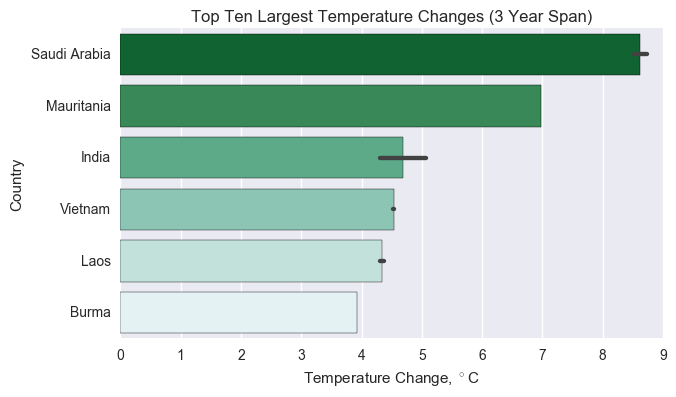

In [9]:
plt.figure(figsize=(7,4))
ax = sns.barplot(data['AbsTempChange'][0:10],data['Country'][0:10],palette='BuGn_r')
ax.set_xlabel('Temperature Change, $^\circ$C')
ax.set_title('Top Ten Largest Temperature Changes (3 Year Span)')
plt.savefig("./ana_3/topTenDiff.pdf", bbox_inches='tight')

In [143]:
def plot(zoo):
    holder = countryTempAvg[countryTempAvg['Country'] == zoo]
    plt.plot(holder['Year'],holder['AverageTemperature'])

In [160]:
def plotData(zoo):
    data = DataFrame()
    avgHolder = countryTempFull.groupby(['Country','Year']).mean().reset_index(drop=False)
    for each in zoo:
        holderTemp = avgHolder[avgHolder['Country'] == each]
#         holderTemp = holderTemp[holderTemp['Year'] >= cutOffYear]
#         holderAvg = holderTemp['AverageTemperature'].mean()
#         holderTemp['AverageTemperature'] = holderTemp['AverageTemperature'].apply(lambda x : x - holderAvg)

        holderTemp['AverageTemperature'] = savgol_filter(holderTemp['AverageTemperature'], 3, 1)

        holderTemp['Upper'] = holderTemp['AverageTemperature'] + holderTemp['AverageTemperatureUncertainty']
        holderTemp['Lower'] = holderTemp['AverageTemperature'] - holderTemp['AverageTemperatureUncertainty']

        holderT = holderTemp[['Country']+['Year']+['AverageTemperature']]
        holderT.columns = ['Country','Year','AvgTemp']
        holderT['Count'] = 0
        holderU = holderTemp[['Country']+['Year']+['Upper']]
        holderU.columns = ['Country','Year','AvgTemp']
        holderU['Count'] = 1
        holderL = holderTemp[['Country']+['Year']+['Lower']]
        holderL.columns = ['Country','Year','AvgTemp']
        holderL['Count'] = 2

        name = each.replace(" ","")
        name = 'all'+name

        name = holderT.append(holderU)
        name = name.append(holderL).sort_values('Year').reset_index(drop=True)

        data = data.append(name)
    return data

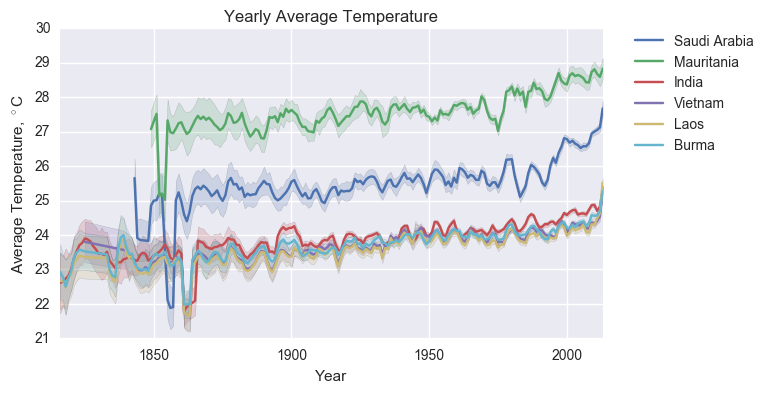

In [178]:
plt.figure(figsize=(7,4))
stuff = plotData(data['Country'].unique()[:6])
ax=sns.tsplot(time='Year', value='AvgTemp',unit='Count',condition='Country',data=stuff)
ax.set_ylabel('Average Temperature, $^\circ$C')
ax.set_title('Yearly Average Temperature')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("./ana_3/maxDiffs.pdf", bbox_inches='tight')